Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells. Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib inline
import os
import sys
import numpy as np
import scipy.ndimage as nd
import scipy.spatial as ss
import matplotlib.pyplot as plt

import geopandas as gp
import mplleaflet
from shapely.geometry import box as shape_box
from shapely.geometry import Polygon

from copy import deepcopy
import gdal
gdal.UseExceptions()
import ogr
import osr
import pandas as pd
from model_specs import *
from gen_mod_dict import *
pth = 'MFGrid/mfgrid'
sys.path.append(pth)
import grid as modgrid

from ipywidgets import interact, Dropdown
from IPython.display import display

The next cell doesn't do anything in the notebook. It is the template
for turning the notebook into a batch python script. To run in batch mode, download this notebook as a python script and place the entire body of the script in place of the "pass" command after the "try" statement. Make sure the indent level is the same as "pass".  

In [2]:
for key, value in model_dict.items():   # from "gen_mod_dict.py"
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying CoastalCT
trying Assabet


In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

# Preliminary stuff

In [4]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}'.format(md))

The model being processed is CoastalCT


In [5]:
proj_dir   # Pathnames from "model_specs.py"

'C:/workspace/gw-general-models/Genmod1.0/subprojects/siteGeneral'

In [6]:
# ib_filter = ms['ib_filter']

model_ws = os.path.join(proj_dir, ms['ws'])   # values from "gen_mod_dict.py"
nhd_basin_dir = ms['vpu']
rpu = ms['rpu']
domain_file = os.path.join(model_ws, ms['df'])

Make pathnames for the NHD and Glacial Texture map

In [7]:
# Pathnames from "model_specs.py"
flow_file = os.path.join(nhd_dir, nhd_basin_dir, 'NHDSnapshot', 'Hydrography', 'NHDFlowline.shp')
lake_file = os.path.join(nhd_dir, nhd_basin_dir, 'NHDSnapshot', 'Hydrography', 'NHDWaterbody.shp')
VAA_file = os.path.join(nhd_dir, nhd_basin_dir, 'NHDPlusAttributes', 'PlusFlowlineVAA.dbf')
fcode_file = os.path.join(nhd_dir, nhd_basin_dir, 'NHDSnapshot', 'NHDFCode.dbf')
slope_file = os.path.join(nhd_dir, nhd_basin_dir, 'NHDPlusAttributes', 'ElevSlope.dbf')

#stack_file = os.path.join(geol_dir, 'factor_added_Stack_map.shp')
# subsurf_file = os.path.join(geol_dir, 'Subsurface_(Selected_Areas).shp')
# surfmat_file = os.path.join(geol_dir, 'Surficial_Materials.shp')
# veneer_file = os.path.join(geol_dir, 'Veneer_(Selected_Areas).shp')

print(flow_file)
print(lake_file)
print(VAA_file)
print(fcode_file)
print(slope_file)

C:/workspace/gw-general-models/Genmod1.0/input_data/NHDPlusV2Data\NHDPlusNE_MA/NHDPlus01_02\NHDSnapshot\Hydrography\NHDFlowline.shp
C:/workspace/gw-general-models/Genmod1.0/input_data/NHDPlusV2Data\NHDPlusNE_MA/NHDPlus01_02\NHDSnapshot\Hydrography\NHDWaterbody.shp
C:/workspace/gw-general-models/Genmod1.0/input_data/NHDPlusV2Data\NHDPlusNE_MA/NHDPlus01_02\NHDPlusAttributes\PlusFlowlineVAA.dbf
C:/workspace/gw-general-models/Genmod1.0/input_data/NHDPlusV2Data\NHDPlusNE_MA/NHDPlus01_02\NHDSnapshot\NHDFCode.dbf
C:/workspace/gw-general-models/Genmod1.0/input_data/NHDPlusV2Data\NHDPlusNE_MA/NHDPlus01_02\NHDPlusAttributes\ElevSlope.dbf


In [8]:
def process_raster_data(src, method, conversion=1.0):
    '''
    Takes a raster data source (ESRI grid, GeoTiff, .IMG and many other formats)
    and returns a numpy array. Arrangment of pixels is given as input and may 
    correspond to a MODFLOW grid.
    
    src : string
        complete path to raster data source
    method : string
        gdal method for interpolation. Choices are:
            gdal.GRA_NearestNeighbour 
                Nearest neighbour (select on one input pixel)
            gdal.GRA_Bilinear
                Bilinear (2x2 kernel)
            gdal.GRA_Cubic
                Cubic Convolution Approximation (4x4 kernel)
            gdal.GRA_CubicSpline
                Cubic B-Spline Approximation (4x4 kernel)
            gdal.GRA_Lanczos
                Lanczos windowed sinc interpolation (6x6 kernel)
            gdal.GRA_Average
                Average (computes the average of all non-NODATA contributing pixels)
            gdal.GRA_Mode
                Mode (selects the value which appears most often of all the sampled points)
            gdal.GRA_Max
                Max (selects maximum of all non-NODATA contributing pixels)
            gdal.GRA_Min
                Min (selects minimum of all non-NODATA contributing pixels)
            gdal.GRA_Med
                Med (selects median of all non-NODATA contributing pixels)
            gdal.GRA_Q1
                Q1 (selects first quartile of all non-NODATA contributing pixels)
            gdal.GRA_Q3
                Q3 (selects third quartile of all non-NODATA contributing pixels)

    conversion : float
        factor to be applied to raw data values to change units

    requires global variables (for now):
    NCOL, NROW : number of rows and columns
    gt : geotransform list
    shapeproj : coordinate reference system of NHDPlus (or other desired projection)
    hnoflo : to be used as missing data value (from model_spec.py)

    returns:
    2D array of raster data source projected onto model grid. 
    Returns a zero array with the correct shape if the source does not exist.
    '''
    if os.path.exists(src):
        rast = gdal.Open(src)

        dest = make_grid(NCOL, NROW, gt, shapeproj)
        gdal.ReprojectImage(rast, dest, rast.GetProjection(), shapeproj, method)

        grid = dest.GetRasterBand(1).ReadAsArray()

        grid = grid * conversion

        dest = None
        rast = None
    else:
        grid = np.ones((NROW, NCOL)) * hnoflo
        print('Data not processed for\n{}\n Check that the file exists and path is correct'.format(src))

    return grid

def process_vector_data(src, attribute):
    '''
    Takes a vector data source (ESRI shapefile) and returns a numpy array.
    Arrangment of pixels is given as input and may correspond to a MODFLOW grid.

    src : complete path to vector data source
    attribute : field in data table to assign to rasterized pixels
    
    requires global variables:
    NCOL, NROW : number of rows and columns
    gt : geotransform list
    shapeproj : coordinate reference system of NHDPlus
    hnoflo : to be used as missing data value (from model_spec.py)
    
    returns:
    2D array of vector data source projected onto model grid.
    Returns a zero array with the correct shape if the source does not exist.
    '''
    if os.path.exists(src):

        datasource = ogr.Open(src)
        layer = datasource.GetLayer()

        src = make_grid(NCOL, NROW, gt, shapeproj, 0)
        args = 'ATTRIBUTE={}'.format(attribute)
        gdal.RasterizeLayer(src, [1], layer, options = [args])

        grid = src.GetRasterBand(1).ReadAsArray()

        src = None
        dst = None        
    else:
        grid = np.ones((NROW, NCOL)) * hnoflo
        print('Data not processed for\n{}\n Check that the file exists and path is correct'.format(src))

    return grid

def make_raster(dst_file, data, NCOL, NROW, gt, proj, nodata):
    '''
    Writes numpy array to a GeoTiff file.
    
    dst_file : name of file to write
    data : 2D numpy array
    NCOL, NROW : number of rows and columns. These may coincide with a MODFLOW grid.
    gt : 6-element geotransform list [C, A, B, F, E, D]. Gives the coordinates of one pixel
        (the upper left pixel). If there is no rotation, B=D=0. If cells are square, A=-E.   
        Letter designations come from the original documentation.
        
        C = x coordinate in map units of the upper left corner of the upper left pixel
        A = distance from C along x axis to upper right pixel corner of the upper left pixel
        B = distance from C along x axis to lower left pixel corner of the upper left pixel,
        F = y coordinate in map units of the upper left corner of the upper left pixel
        E = distance from C along y axis to lower left pixel corner of the upper left pixel
        D = distance from C along y axis to upper right pixel corner of the upper left pixel
        
    proj : projection of the GeoTiff
    nodata : value to use as missing data in the GeoTiff
    '''
    import gdal
    driver = gdal.GetDriverByName("GTiff")
    dst = driver.Create(dst_file, NCOL, NROW, 1, gdal.GDT_Float32)
    dst.SetGeoTransform(gt)
    dst.SetProjection(proj)
    band = dst.GetRasterBand(1)
    band.SetNoDataValue(nodata)
    band.WriteArray(data)
    dst = None

def make_grid(NCOL, NROW, gt, proj, nodata=hnoflo):
    '''
    Creates a blank raster image in memory.
        
    NCOL, NROW : number of rows and columns. These may coincide with a MODFLOW grid.
    gt : 6-element geotransform list [C, A, B, F, E, D]. Gives the coordinates of one pixel
        (the upper left pixel). If there is no rotation, B=D=0. If cells are square, A=-E.   
        Letter designations come from the original documentation.
        
        C = x coordinate in map units of the upper left corner of the upper left pixel
        A = distance from C along x axis to upper right pixel corner of the upper left pixel
        B = distance from C along x axis to lower left pixel corner of the upper left pixel,
        F = y coordinate in map units of the upper left corner of the upper left pixel
        E = distance from C along y axis to lower left pixel corner of the upper left pixel
        D = distance from C along y axis to upper right pixel corner of the upper left pixel
        
    proj : projection of the GeoTiff
    nodata : value to use as missing data in the GeoTiff
    '''
    import gdal
    mem_drv = gdal.GetDriverByName('MEM')
    grid_ras = mem_drv.Create('', NCOL, NROW, 1, gdal.GDT_Float32)
    grid_ras.SetGeoTransform(gt)
    grid_ras.SetProjection(shapeproj)
    band = grid_ras.GetRasterBand(1)
    band.SetNoDataValue(nodata)
    array = np.zeros((NROW,NCOL))
    band.WriteArray(array)
    return grid_ras

def process_mohp_data(tif_files):
    '''
    Loops a list of MOHP tif files. The rest of the algorithm is similar to the function
    "process_raster_data" except that a transformation from the ESRI WKT format to a generic
    format is needed. When MOHP data source is finalized, this function can be modified
    to work with the final format.
    
    src : complete path to raster data source
    method : gdal method for interpolation
    conversion : factor to be applied to raw data values to change units

    requires global variables (for now):
    NCOL, NROW : number of rows and columns
    gt : geotransform list
    shapeproj : coordinate reference system of NHDPlus (or other desired projection)
    hnoflo : to be used as missing data value (from model_spec.py)

    returns:
    2D array of raster data source projected onto model grid. Each column contains
    a different stream order MOHP. Each row corresponds to a model cell. 
    Number of rows is NCOL x NCOL. Number of columns is number of stream orders present.
    '''
    import gdal
    gdal.UseExceptions()
    import ogr
    import osr
    
    arr = np.zeros((NCOL * NROW, len(tif_files)))
    if tif_files != []:
        for col, src in enumerate(tif_files):
            hp = gdal.Open(src)

            dest = make_grid(NCOL, NROW, gt, shapeproj)

            srs = osr.SpatialReference()
            srs.ImportFromWkt(hp.GetProjection())
            srs.MorphFromESRI()
            hp_prj = srs.ExportToWkt()
            hp.SetProjection(hp_prj)

            gdal.ReprojectImage(hp, dest, hp.GetProjection(), shapeproj, gdal.GRA_NearestNeighbour)

            hp_grd = dest.GetRasterBand(1).ReadAsArray()
            hp_grd = hp_grd / 10000.

            dst = None
            hp = None
            
            arr[:, col] = hp_grd.ravel()
    return arr

def make_clockwise(coords):
    '''
    Function to determine direction of vertices of a polygon (clockwise or CCW).
    Probably not needed, but here just in case. 
    
    coords : array with dim (n, 2)
            n is number of vertices in the polygon. The last vertex is the same 
            as the first to close the polygon. The first column is x and the second is y.
    '''
    # if the points are counterclockwise, reverse them
    x1 = coords[:-1, 0]
    x2 = coords[1:, 0]
    y1 = coords[:-1, 1]
    y2 = coords[1:, 1]
    ccw = np.sum((x2 - x1) * (y2 + y1)) < 0
    if ccw:
        coords = np.flipud(coords)
        print('yup, coordinates are ccw')
        print("let's change them to CW")
    return coords

# test data for make_clockwise

# print('clockwise')
# x = np.array([1, 1, 2, 2, 1])
# y = np.array([1, 2, 2, 1, 1])
# coords = np.array(zip(x, y))
# c = make_clockwise(coords)
# print( c)
# print('\n')
# print('CCW')
# x = np.array([1, 2, 2, 1, 1])
# y = np.array([1, 1, 2, 2, 1])
# coords = np.array(zip(x, y))
# c = make_clockwise(coords)
# print( c)

import pysal as ps
import numpy as np
import pandas as pd
import os
import ast
from shutil import copyfile

def dbf2df(dbf_path, index=None, cols=False, incl_index=False):
    '''
    Read a dbf file as a pandas.DataFrame, optionally selecting the index
    variable and which columns are to be loaded.

    __author__  = "Dani Arribas-Bel <darribas@asu.edu> "
    ...

    Arguments
    ---------
    dbf_path    : str
                  Path to the DBF file to be read
    index       : str
                  Name of the column to be used as the index of the DataFrame
    cols        : list
                  List with the names of the columns to be read into the
                  DataFrame. Defaults to False, which reads the whole dbf
    incl_index  : Boolean
                  If True index is included in the DataFrame as a
                  column too. Defaults to False

    Returns
    -------
    df          : DataFrame
                  pandas.DataFrame object created
    '''
    db = ps.open(dbf_path)
    if cols:
        if incl_index:
            cols.append(index)
        vars_to_read = cols
    else:
        vars_to_read = db.header
    data = dict([(var, db.by_col(var)) for var in vars_to_read])
    if index:
        index = db.by_col(index)
        db.close()
        return pd.DataFrame(data, index=index)
    else:
        db.close()
        return pd.DataFrame(data)

## Calculate model grid coordinates

In general, the steps for creating and populating the MODFLOW grid in GIS space is as follows:

* Read the domain shapefile and store its projection. The shapefile containing outline of model domain must have an attribute called "ibound."
* Make the convex hull of the model domain and extract the coordinates of the hull.
* Iterate around the sides of the convex hull, rotating it so that each iteration the next side is parallel to the x axis.
* Make a bounding box around the rotated hull and store its area.
* The angle of rotation that corresponds to the bounding box with the smallest area is the rotation that produces the smallest number of inactive cells.
* Make a geotransform list so that any arbitrary data can be projected on to the model grid in GIS space. 

In [9]:
domain_diss = gp.read_file(domain_file)
prj = domain_diss.crs

Open the NED grid from NHDPlus to get the projection. NHDPlus lines are in geographic coordinates rather than a projected coordinate reference system. Extract the projection as WKT, convert it to Proj.4 format, then parse that into a Python dictionary.

In [10]:
src = os.path.join(nhd_dir, nhd_basin_dir, 'NEDSnapshot', rpu, 'elev_cm')
ned = gdal.Open(src)
shapeproj = ned.GetProjection()
srs = osr.SpatialReference()
srs.ImportFromWkt(shapeproj)
prj4 = (srs.ExportToProj4()).split('+')
prj4 = dict([item.split('=') for item in prj4 if len(item.split('=')) == 2])

In [11]:
domain_diss.to_crs(prj4, inplace=True)

In [12]:
domain_diss.ibound = 1

In [13]:
# domain_diss.plot()
domain_diss.to_file(os.path.join(model_ws, 'domain_outline.shp'))

Uncomment the following lines to generate a leaflet map of the model domain.

In [14]:
#ax = domain_diss.plot()
#mplleaflet.display(fig=ax.figure, crs=prj)

Find convex hull and extract the coordinates of its vertices. (Add the function to change to clockwise here if needed.)

In [15]:
hull = domain_diss.convex_hull
coords2 = np.array(hull[0].exterior.coords[:])

Calculate the domain (dc) and angle (da) of each side.

In [16]:
dc2 = np.diff(coords2, axis=0)
da2 = np.arctan2(dc2[:,1], dc2[:,0])

Rotate to each side of the convex hull and calculate the area of each bounding box.

In [17]:
num_vert = da2.shape[0]
area2 = np.zeros((num_vert))
for i in range(num_vert):
    hull_rot = hull.rotate(-da2[i], origin=tuple(coords2[i, :]), use_radians=True)
    minx, miny, maxx, maxy = hull_rot.bounds.iloc[0]
    area2[i] = (maxx - minx) * (maxy - miny)

Construct a rectangular polygon and geoseries corresponding to the minimum area bounding box.

In [18]:
ii2 = np.argmin(area2)
hull_rot = hull.rotate(-da2[ii2], origin=tuple(coords2[ii2, :]), use_radians=True)
# minx, miny, maxx, maxy = hull_rot.bounds.iloc[0]
# temp_poly = shape_box(minx, miny, maxx, maxy, ccw=False)
# temp_gdf = gp.GeoSeries(temp_poly)
temp_gdf = hull_rot.envelope

Rotate the bounding box back to its original coordinate framework and set its projection.

In [19]:
box = temp_gdf.rotate(da2[ii2], origin=tuple(coords2[ii2, :]), use_radians=True)
box.crs = prj4

Save the shapefile.

In [20]:
box.to_file(os.path.join(model_ws, 'clip_box.shp'))

Extract the geometry for use later in clipping NHD flowlines.

In [21]:
clip = box.geometry[0]

Find a visualing pleasing origin and use it as the model origin. 

Extract the coordinates of the box; each line is an (x, y) pair.

In [22]:
pts = np.array(box[0].exterior.coords[:])
pts = make_clockwise(pts)

yup, coordinates are ccw
let's change them to CW


The first and last vertices of a polygon are identical, so strip off the last vertex.

In [23]:
# pts = pts[:-1, :]

Find the line containing the coordinates of the apex (ymax) of the hull.

In [24]:
ymax = np.argmax(pts[:, 1])

Wrap (roll) the lines of the array around so that the apex is at the top of the array (first line).

In [25]:
# pts = np.roll(pts, -ymax, axis=0)

Add the first point (ymax) back to the last position to complete the polygon.

In [26]:
# pts = np.vstack((pts, pts[0, :]))

Calculate the domain (dc) and angle (da) of each side.

In [27]:
dc = np.diff(pts, axis=0)
da = np.arctan2(dc[:, 1], dc[:, 0])

Determine shape of bounding box to determine row and column directions.

In [28]:
# dx, dy = np.amax(dc, axis=0)
# is_tall = dx < dy

Calculate the geotransform list to be used for creating raster images later. See the function "make_raster" for an explanation. Theta is not used to make rasters; it's used to rotate NHD flowlines.

The orientation of the top side of the model grid is determined by the angle from (x, ymax) to the next vertex to its right in a clockwise direction:

* If the angle is < -45 degrees (-pi/4), the top side is to the left of (x, ymax) and the origin is (x, ymax - 1)
    
* If the angle is >= -45 degrees (-pi/4), the top side is to the right of (x, ymax) and the origin is (x, ymax)

In [29]:
side_lengths = np.hypot(dc[:, 0], dc[:, 1])

if da[ymax] < (np.pi / -4):
    or_cor = ymax - 1
else:
    or_cor = ymax

theta = da[or_cor]
origin = pts[or_cor, :]
x_len = side_lengths[or_cor]
y_len = side_lengths[or_cor - 1]

if md=="CoastalCT_CT" or md=="CoastalCT_initial" or md=="CoastalCT":
    origin = pts[or_cor-1,:]

Calculate the number of rows and columns for the L given in model_spec.py.

In [30]:
NROW = np.int(np.ceil(y_len / L))
NCOL = np.int(np.ceil(x_len / L))

In [31]:
print (NROW, NCOL)

281 746


Replace the number of rows and columns with those from an existing model if one is present.

In [32]:
keys = ms.keys()
if 'NROW' in keys:
    NROW = ms['NROW']
    NCOL = ms['NCOL']
    LX = x_len / NCOL
    LY = y_len / NROW
else:
    LX = L
    LY = L

In [33]:
A = LX * np.cos(theta)
B = LY * np.sin(theta)
D = LX * np.sin(theta)
E = LY * -np.cos(theta)

gt = [origin[0], A, B, origin[1], D, E]

Write a file of information that summarizes all of the above stuff.

In [78]:
grid_spec_file = os.path.join(model_ws, 'grid_spec.txt')
with open(grid_spec_file, 'w') as f:
    line = 'Source locations\n'
    f.write(line)
    for key, val in ms.items():
        f.write('  {} : {}\n'.format(key, val))
    line = '\nUpper left corner x and y projected coordinates\n'
    f.write(line)
    line = '{} {}\n\n'.format(origin[0], origin[1])
    f.write(line)
    line = 'Rotation about upper left corner in radians and degrees from positive x axis\n'
    f.write(line)
    line = '{} {}\n\n'.format(theta, theta * 180 / np.pi)
    f.write(line)
    line = 'Grid corner projected coordinates\n'
    f.write(line)
    for row in pts:
        f.write(' {:0.2f}  {:0.2f} '.format(*row))
    line = '\nCoordinate reference system\n'
    f.write(line)
    for key, val in prj4.items():
        f.write('    {} : {}\n'.format(key, val))
    line = '\n\nGeotransformation block\n'
    f.write(line)
    line = '{} {} {} {} {} {}'.format(*gt)
    f.write(line)
    line = '\n\nGrid block\n'
    f.write(line)
    line = 'NROW {} NCOL {}'.format(NROW, NCOL)
    f.write(line)
    line = '\n\nCell Size\n'
    f.write(line)
    line = '{} '.format(L)
    f.write(line)

## Process river flowlines and lake polygons

Read HD flowlines and associated tables.

In [35]:
flowlines = gp.read_file(flow_file)
VAA_tab = dbf2df(VAA_file, cols=['ComID', 'StreamOrde'])
slope_tab = dbf2df(slope_file, cols=['COMID', 'MAXELEVSMO', 'MINELEVSMO'])
fcode_tab = dbf2df(fcode_file, cols=['FCode', 'Hydrograph'])

Extract projection information, which for NHDPlus flowlines will be geographic (lat long) coordinates. Project grid box outline to the NHD (geographic) coordinates. Clip the NHD to the box and project it back to the projected coordinate system (probably Albers). Note: the crs from NHD is given below as epsg code 4269.  This is the same as a plain NAD83 crs.

In [36]:
latlong_prj = flowlines.crs
latlong_box = box.to_crs(crs=latlong_prj)
latlong_clip = latlong_box.geometry[0]
lines = flowlines['geometry'].intersection(latlong_clip)
lines = lines.to_crs(crs=prj4)

Add fields from the NHD back to the clipped lines.

In [37]:
lines = pd.DataFrame(lines, columns=['geometry'])
lines['COMID'] = flowlines.COMID
lines['FCODE'] = flowlines.FCODE
lines['REACHCODE'] = flowlines.REACHCODE
lines['LENGTHKM'] = flowlines.LENGTHKM
f = lambda x: x[:8]
lines['HUC_8'] = lines.REACHCODE.map(f)

Merge selected fields from the associated tables into the clipped lines.

In [38]:
lines = lines.merge(VAA_tab, how='inner', left_on='COMID', right_on='ComID')
lines = lines.merge(slope_tab, how='inner', left_on='COMID', right_on='COMID')
lines = lines.merge(fcode_tab, how='inner', left_on='FCODE', right_on='FCode')

lines['maxft'] = lines.MAXELEVSMO / 100.
lines['minft'] = lines.MINELEVSMO / 100.
lines['StreamOrde'] = lines.StreamOrde

lines.drop(['FCode', 'ComID'], axis=1, inplace=True)
# lines = lines[lines.Hydrograph != 'Intermittent']
lines['intermit'] = lines.Hydrograph == 'Intermittent'

Make a GeoDataFrame from the lines and get rid of lines outside the box (model) area. 

In [39]:
lines = gp.GeoDataFrame(lines, crs=prj4, geometry=lines.geometry)
lines = lines[-lines.geometry.isnull()]

If a HUC-8 is provided in domain_diss, do the above operations again, this time for the basin outline rather than the model box.  It's faster to perform the operations in two steps like this. 

In [40]:
prj_clip = domain_diss.geometry[0]
lines_clip = lines['geometry'].intersection(prj_clip)

lines_clip = gp.GeoDataFrame(lines_clip, crs=prj4, geometry=lines_clip.geometry)
lines_clip['COMID'] = lines.COMID
lines_clip['FCODE'] = lines.FCODE
lines_clip['REACHCODE'] = lines.REACHCODE
lines_clip['HUC_8'] = lines.HUC_8

lines_clip['maxft'] = lines.maxft
lines_clip['minft'] = lines.minft
lines_clip['StreamOrde'] = lines.StreamOrde
lines_clip['LENGTHKM'] = lines.LENGTHKM
lines_clip['intermit'] = np.int32(lines.intermit)

lines_clip.drop(0, axis=1, inplace=True)
lines_clip = lines_clip[-lines_clip.geometry.isnull()]

Save the clipped flowlines to a shapefile

In [41]:
lines_clip.to_file(os.path.join(model_ws, 'NHD_clip.shp'))

Calculate values (offset and rotation) to transform flowlines to model grid reference system

In [42]:
xoff = origin[0]
y_len_grid = NROW * LY
yoff = origin[1] - y_len_grid

Rotate and translate flowlines to model grid reference system

In [43]:
lines_rot = lines_clip.rotate(-theta, origin=tuple(origin), use_radians=True).translate(xoff=-xoff, yoff=-yoff)

Create drain/river package input dictionary of lists (for FloPy)

* First create a ModflowGrid object.  This class is available in FloPy and makes doing the intersections of flowlines with model grid easier.

In [44]:
NLAY = 1
mfg = modgrid.ModflowGrid(NLAY, NROW, NCOL, LX, LY, 0)

NPER =  1 
drn_dict = {}
perlist = []
lineset = range(lines.shape[0])
riv_loc = np.zeros((NROW,NCOL), np.int)
riv_stg = np.zeros((NROW,NCOL), np.float)
order_dict = {}
per_order_list = []

* Loop through each stress period. Each set of drains/rivers is a value in a dictionary whose key is the stress period.
* Two parallel lists are used: lines_clip (in geographic space) and lines.rot (in model space)
 * intersections are done in model space so that lengths of flowline in model cell can be calculated
 * attributes aren't merged into lines_rot, so attributes have to be taken from lines_clip
 * the simple rotation and translation seems to preserve the order in both lists, but this could be a potential issue
* mfg.intersection returns
 * nodes : tuples of (row, column) that are intersected by a flowline reach
 * lengths : scalar lengths of flowline in each model cell corresponding to the above tuple
* Each reach has a starting and ending elevation from NHDPlus. Interpolate these to the midpoint of each intersected segment in each cell. If starting and ending elevations are the same, return zero-gradient stream segments.
* Loop through each set of nodes for each reach, adding each one to the list of drain/river cells for the current stress period. 
* Some reaches have (probably erroneously) have begining and ending stages = 0. These are ignored, but this could be an issue for coastal areas with discharge to estuaries (stage = 0).
* Maintain a second list with information on reach ID, original length, and stream order

In [45]:
for period in range(NPER):
    for rindex, reach in lines_clip.iterrows():
        try:
            data = np.array(lines_rot.geometry[rindex].coords[:])
            nodes, lengths = mfg.intersection(data, 'line')

    #         interpolate the begin and end segment elevation to the midpoint of the feature in each cell
            cumlen = np.cumsum(lengths)
            midpoint = cumlen - np.asarray(lengths) / 2
            rise = reach.maxft - reach.minft
            grad = rise / cumlen[-1]
            stage = reach.maxft - midpoint * grad
            if reach.maxft == reach.minft:
                stage = np.ones_like(stage) * reach.minft
    #         loop through the cells intersected by the feature
            for nindex, (row, col) in enumerate(nodes):
                riv_loc[row, col] = 1
                temp = [0, row, col, stage[nindex], lengths[nindex]]
                temp2 = [0, row, col, reach.StreamOrde, reach.REACHCODE, reach.LENGTHKM, reach.intermit]        
                if stage[nindex] != 0:
                    perlist.append(temp)
                    per_order_list.append(temp2)
        except (NotImplementedError, IndexError):
            pass
    drn_dict[period] = perlist
    order_dict[period] = per_order_list

Iterate through the drain/river list and put those values in an array using (row, column). 

In [46]:
# riv_data = drn_dict
riv_len = np.ones((NROW, NCOL), np.float) * hnoflo
riv_stg = np.ones((NROW, NCOL), np.float) * hnoflo

riv_data = drn_dict[0]
for [l, r, c, s, cond] in riv_data:
    row = int(r)
    col = int(c)
    stg = float(s)
    stk = float(cond)
    riv_len[row, col] = stk
    riv_stg[row, col] = stg

Do the same as above but with the lists of stream order and reach ID. lengthkm is the original reach length from NHDPlus, not the intersected length.

In [47]:
riv_data = order_dict
riv_ord = np.ones((NROW ,NCOL), np.int) * hnoflo
riv_comid = np.zeros((NROW, NCOL)).astype(str) 
riv_reachlen = np.ones((NROW, NCOL), np.int) * hnoflo
riv_intermit = np.zeros((NROW, NCOL)).astype(bool) 

riv_data = order_dict[0]
for [l, r, c, order, comid, lengthkm, intermit] in riv_data:
    row = int(r) 
    col = int(c) 
    order = int(order)
    reachlen = float(lengthkm)
    riv_ord[row, col] = order
    riv_comid[row, col] = comid
    riv_reachlen[row, col] = reachlen
    riv_intermit[row, col] = intermit

Add an attribute to the lake file for rasterizing later.

In [48]:
# all_lakes = gp.read_file(lake_file)
lakes = gp.read_file(lake_file)
lakes['is_lake'] = 1
lakes.to_crs(prj4, inplace=True)
lakes.to_file(os.path.join(model_ws, 'lakes.shp'))

## Project data sources onto modflow grid, store the data in a file called model_grid.csv, and write Geotiff images of all the data

Create a blank dataframe and add 2D node numbers (NROW * NCOL) as the index.

In [49]:
model_grid = pd.DataFrame()
model_grid['node_num'] = np.arange(NROW * NCOL)
model_grid.set_index('node_num', inplace=True)

Open and read the NED grid for the current model area and store its projection. All other data sources will be projected into this projection. 

In [50]:
src = os.path.join(nhd_dir, nhd_basin_dir, 'NEDSnapshot', rpu, 'elev_cm')
ned = gdal.Open(src)
shapeproj = ned.GetProjection()
ned = None

Add vector data sources to model_grid dataframe.
* Better: put parameters in a nested list and loop through it.

If the model is from an inset or other more detailed model, read the ibound array based on the corresponding General Model for consistency. This is coded in the second block below.

In [51]:
# if 'ibound_src' in ms.keys():
#     ib_src = model_dict[ms['ibound_src']]['ws']
#     ib_src = os.path.join(proj_dir, ib_src)
#     ib_file = model_dict[ms['ibound_src']]['df']
#     ib_shp = os.path.join(ib_src, ib_file)
#     grid = process_vector_data(ib_shp, 'ibound')
#     model_grid['ibound'] = grid.ravel()   
# else:
src = os.path.join(model_ws, 'domain_outline.shp')
grid = process_vector_data(src, 'ibound')
model_grid['ibound'] = grid.ravel()

#src = os.path.join(model_ws, gage_file)
#grid = process_vector_data(src, 'GAGE_ID')
#model_grid['gage_id'] = grid.ravel()

src = os.path.join(model_ws, 'NHD_clip.shp')
grid = process_vector_data(src, 'StreamOrde')
model_grid['stream_order'] = grid.ravel()

gess_geology_file = 'GESS_poly.gdb'
src = os.path.join(qa_dir, gess_geology_file)
grid = process_vector_data(src, 'CrseStratSed')
model_grid['gess_poly'] = grid.ravel()

src = os.path.join(model_ws, 'lakes.shp')
grid = process_vector_data(src, 'is_lake')
model_grid['lake'] = grid.ravel()

src = os.path.join(kauffman_surf_thick_dir, 'SedimentAquiferCharacteristics.shp')
grid = process_vector_data(src, 'Quaternary')
model_grid['kauffman_thk'] = grid.ravel()

if 'zone_src' in ms.keys():
    zone_src = ms['zone_src']
    src = os.path.join(os.getcwd(),"..","input_data","Zones",zone_src)
    grid = process_vector_data(src,'Zone')
    model_grid['zone'] = grid.ravel()
    
if 'sewer_src' in ms.keys():
    sewer_src = ms['sewer_src']
    src = os.path.join(os.getcwd(),"..","input_data","WaterUse",sewer_src)
    grid = process_vector_data(src,'Sewer')
    model_grid['sewer'] = grid.ravel()
    
if 'pws_src' in ms.keys():
    pws_src = ms['pws_src']
    src = os.path.join(os.getcwd(),"..","input_data","WaterUse",pws_src)
    grid = process_vector_data(src,'PWS')
    model_grid['pws'] = grid.ravel()
    
if 'well_src' in ms.keys():
    well_src = ms['well_src']
    src = os.path.join(os.getcwd(),"..","input_data","WaterUse",well_src)
    grid = process_vector_data(src,'Flux')
    model_grid['well_Flux'] = grid.ravel()
    
    grid = process_vector_data(src,'APA')
    model_grid['well_APA'] = grid.ravel()
    

Add raster data sources to model_grid dataframe.
* Better: put parameters in a nested list and loop through it.

In [52]:
src = os.path.join(nhd_dir, nhd_basin_dir, 'NEDSnapshot', rpu, 'elev_cm')
grid = process_raster_data(src, gdal.GRA_Bilinear, 0.01)
model_grid['ned'] = grid.ravel() # units of meters

src = os.path.join(nhd_dir, nhd_basin_dir, 'NEDSnapshot', rpu, 'elev_cm')
grid = process_raster_data(src, gdal.GRA_Average, 0.01)
model_grid['ned_mean'] = grid.ravel() # units of meters

src = os.path.join(os.getcwd(),"..","input_data","CoastalBoundary","CoastalBoundary_ned.tif")
grid = process_raster_data(src, gdal.GRA_Bilinear, 0.01)
model_grid['ned_coast_min'] = grid.ravel() # units of meters

src = os.path.join(nhd_dir, nhd_basin_dir, 'NHDPlusCatchment', 'cat')
grid = process_raster_data(src, gdal.GRA_NearestNeighbour, 1)
model_grid['catchment'] = grid.ravel()

src = os.path.join(soller_surf_thick_dir, 'sim3392_sheet1_driftthickness.img')
grid = process_raster_data(src, gdal.GRA_Bilinear, ft2m) # convert feet to meters
model_grid['soller_thk'] = grid.ravel()

src = os.path.join(soller_bedrock_topo_dir, 'sim3392_sheet2_bedrocktopo.img')
grid = process_raster_data(src, gdal.GRA_Bilinear, ft2m) # convert feet to meters
model_grid['bedrock_el'] = grid.ravel()

src = os.path.join(nlcd_dir, 'nlcd_2011_landcover_2011_edition_2014_10_10.img')
grid = process_raster_data(src, gdal.GRA_Mode, 1)
model_grid['nlcd'] = grid.ravel()

#population density
src = os.path.join(pop_den_dir,'pden2010_60m.tif')
grid = process_raster_data(src,gdal.GRA_Average,((L*L/1000/1000))) #converts from people / km2 to people / model cell
model_grid['population']=grid.ravel()


#Three sources for recharge values
#SWB_NAWQA published values
src = os.path.join(alt_recharge_SWB_NAWQA, 'SWB_Nawqa_mm.tif') #SWB_NAWQA, published, values in this file are mm/year, need to convert to m
grid = process_raster_data(src, gdal.GRA_Bilinear, 0.001)
model_grid['rch_eff_m_SWB_NAWQA'] = grid.ravel()


#Reitz published values
src = os.path.join(recharge_reitz, 'RC_eff_2013.tif') #Reitz, published, values in this file are m/year, no need to convert
grid = process_raster_data(src, gdal.GRA_Bilinear, 1.0)
model_grid['rch_eff_m_Reitz_2013'] = grid.ravel()

#The Wolock recharge below is included as an alternative to Reitz for comparison purposes; user will have to specify in JN3
src = os.path.join(alt_recharge_wolock, 'rech48grd') #Wolock, published, values in this file are mm/year, need to convert to m
grid = process_raster_data(src, gdal.GRA_Bilinear, 0.001)
model_grid['rch_m_Wolock'] = grid.ravel()

if 'saltwater_src' in ms.keys():
    
    src = os.path.join(os.getcwd(),"..","input_data","CoastalBoundary","CoastalBoundaryDeep.tif")
    grid = process_raster_data(src,gdal.GRA_Average, 1.0)
    model_grid['Coast_Deep'] = grid.ravel()
    #model_grid[model_grid.Coast_Deep>0]=1
    
    src = os.path.join(os.getcwd(),"..","input_data","CoastalBoundary","CoastalBoundaryShallow.tif")
    grid = process_raster_data(src,gdal.GRA_Average, 1.0)
    model_grid['Coast_Shallow'] = grid.ravel()
    #model_grid[model_grid.Coast_Shallow>0]=1

filter the pws to remove isolated cells with private wells (likely in error)

In [53]:

pws_tmp = deepcopy(model_grid.pws.values.reshape(NROW, NCOL))
ib = model_grid.ibound.values.reshape(NROW,NCOL)
'''
Removes isolated cells from the array.
Args: ibound array (nlay,nrow,ncol)

from Wesley Zell
'''

# Distinguish disconnected clusters of active cells in the IBOUND array.
# 0 is considered background; in MODLFOW, active cells are != 0.
#reverse the counting to make pws the background and private wells the area of interest
pws_tmp[pws_tmp == 0] = 2
pws_tmp [pws_tmp==1]=0
pws_tmp [pws_tmp!=0]=1
pws_tmp = pws_tmp * ib

array_of_cluster_idx, num = nd.measurements.label(pws_tmp)

# Identify the cluster with the most active cells; this is the main active area
areas = nd.measurements.sum(pws_tmp, array_of_cluster_idx,index=array_of_cluster_idx)

#set all clusters with area <= 3 to 0
pws_tmp[areas<=3]=0

#now reverse the numbering
pws_tmp[pws_tmp == 0] = 2
pws_tmp [pws_tmp==1]=0
pws_tmp [pws_tmp!=0]=1
pws_tmp = pws_tmp*ib

model_grid['pws'] = deepcopy(pws_tmp.ravel())

Process MOHP data. Each region could have a different number of stream-order-based MOHP data sources, so this processing has to be handled differently from regular raster sources.  One complication is that the projection information has to be translated from ESRI's custom version of the WKT format.

In [58]:
try:   
    srcdir = mohp_dir
    rpu_file = 'pctdistR{}'.format(int(rpu[3:5]))
    tif_files = []

# search MOHP first-generation directory for tif files and store them in a list
    for root, dirs, files in os.walk(srcdir):
        for f in files:
            if f.endswith('tif'):
                if rpu_file in f:
                    src_pth = os.path.join(root, f)
                    tif_files.append(src_pth)
                
# process MOHP data into an array corresponding to the model grid
    arr = process_mohp_data(tif_files)

# unpack the array and add each column to model_grid
    for col, src in enumerate(tif_files):
        key = os.path.basename(src).split('.')[0]
        key = 'HP_{}'.format(key[9:])
        model_grid[key] = arr[:, col]
    
except:
    pass

In [54]:
try:  
    srcdir = mohp2_dir
    tif_files = []

# search MOHP second-generation directory for tif files and store them in a list
    for root, dirs, files in os.walk(srcdir):
        for f in files:
            if f.endswith('tif'):
                src_pth = os.path.join(root, f)
                tif_files.append(src_pth)

# process MOHP data into an array corresponding to the model grid
    arr = process_mohp_data(tif_files)

# unpack the array and add each column to model_grid
    for col, src in enumerate(tif_files):
        key = os.path.basename(src).split('.')[0]
        key = 'HP2_{}'.format(key.split('_')[0])
        model_grid[key] = arr[:, col]
except:
    pass

In [55]:
try:    
    srcdir = thies2_dir
    tif_files = []

# search MOHP-Thiessen polygon directory for tif files and store them in a list
    for root, dirs, files in os.walk(srcdir):
        for f in files:
            if f.endswith('tif'):
                src_pth = os.path.join(root, f)
                tif_files.append(src_pth)

# process MOHP data into an array corresponding to the model grid
    arr = process_mohp_data(tif_files)

# unpack the array and add each column to model_grid
    for col, src in enumerate(tif_files):
        key = os.path.basename(src).split('.')[0]
        key = 'HPTH_{}'.format(key.split('_')[0])
        model_grid[key] = arr[:, col]
except:
    pass

In [56]:
try: 
    srcdir = pour_dir
    rpu_file = 'or{}'.format(int(rpu[3:5]))
    grid_files = []

# search MOHP pour-point-elevation directory for tif files and store them in a list
    for root, dirs, files in os.walk(srcdir):
        for d in dirs:
            if d[:2] == 'or':
                src_pth = os.path.join(root, d)
                grid_files.append(src_pth)

# process MOHP data into an array corresponding to the model grid
    arr = process_mohp_data(tif_files)

# unpack the array and add each column to model_grid
    for col, src in enumerate(tif_files):
        key = os.path.basename(src).split('.')[0]
        key = 'PP_{}'.format(key[2:])
        model_grid[key] = arr[:, col]
except:
    pass

Filter the ibound array to get rid of disconnected cells.  This is a trial-and-error process. The filter is selected in model_spec.py. One of these filters can be used if there are isolated nodes appearing because of the discretization. The filter is specified in the model dictionary in model_spec.py.

use nd.image.measurements


In [57]:
# ib = model_grid.ibound.reshape(NROW, NCOL)
# if ib_filter == 0:
#     pass
# elif ib_filter == 1:
#     filtr = np.array([[0,1,0], [1,4,1], [0,1,0]])
#     ib = nd.correlate(ib, filtr, mode='constant', cval=0) > 5
# elif ib_filter == 2:
#     # alternate filter 11/5/2014
#     filtr = np.array([[0,0,1,0,0], [0,0,4,0,0], [1,4,16,4,1], [0,0,4,0,0], [0,0,1,0,0]])
#     ib = nd.correlate(ib, filtr, mode='constant', cval=0) > 29
# else: 
#     pass

# ib = ib.astype(int)
# model_grid['ibound'] = ib.ravel()

In [58]:
# An improved filter than that above.
ib = model_grid.ibound.values.reshape(NROW, NCOL)
'''
Removes isolated active cells from the IBOUND array.
Args: ibound array (nlay,nrow,ncol)

from Wesley Zell
'''

# Distinguish disconnected clusters of active cells in the IBOUND array.
# 0 is considered background; in MODLFOW, active cells are != 0.
ib[ib != 0] = 1
array_of_cluster_idx, num = nd.measurements.label(ib)

# Identify the cluster with the most active cells; this is the main active area
areas = nd.measurements.sum(ib, array_of_cluster_idx,\
                         index=np.arange(array_of_cluster_idx.max() + 1))
max_cluster_idx = np.argmax(areas)

# Inactivate all cells that belong to secondary clusters (e.g., islands)
ib[array_of_cluster_idx != max_cluster_idx] = 0
ib = ib.astype(int)
model_grid['ibound'] = ib.ravel()

Filter ibound to make a grid of edge cells. Intersect this with the lake grid. Cell that are on the edge of the model and are in lakes could be treated as GHB cells.  This is not implemented yet, but the code would be very similar to the code above for drain/river cells. FloPy GHB requires a dictionary of lists similar to river/drain.

In [59]:
filtr = np.ones((3,3))
not_solid = nd.correlate(ib, filtr, mode='constant', cval=0) < 9

edge = (ib + not_solid) == 2
edge = edge.astype(int)
model_grid['edge'] = edge.ravel()

lakes_arr = model_grid.lake.values.reshape(NROW, NCOL)
lake_blur = nd.correlate(lakes_arr, filtr, mode='constant', cval=0) > 0

ghb = (edge + lake_blur) == 2
ghb = ghb.astype(int)
model_grid['ghb'] = ghb.ravel()

Add drain/river information to model_grid. 

In [60]:
model_grid['stage'] = riv_stg.ravel()
model_grid['segment_len'] = riv_len.ravel()
model_grid['order'] = riv_ord.ravel()
model_grid['reachcode'] = riv_comid.ravel()
model_grid['reach_intermit'] = riv_intermit.ravel()
model_grid['reach_len'] = riv_reachlen.ravel()
model_grid['reach_int'] = pd.Categorical(model_grid.reachcode).codes

The NHDPlus has a small number of MAXELEVSMO and MINELEVSMO in (mostly?) first order streams that are set to a missing value code -9980. Converted to meters this is -99.80. Replace all such values with the NED value minus 1 (meter). 

In [61]:
model_grid['stage'] = np.where(model_grid.stage == -99.98, model_grid.ned - 1., model_grid.stage)

GHB is used for marine boundaries along cells (and rivers) within the coastal boundary shapefile (marine or estuarine wetlands)

In [63]:
model_grid['ghb_sea']=0
#setting the ghb for cells within deep or shallow marine / estuarine wetlands
model_grid.loc[(model_grid['Coast_Deep']>0) | (model_grid['Coast_Shallow']>0),'ghb_sea']=1

#convert the depth of saltwater to a freshwater head using the depth and the densities of each
#fresh_head = (den_sea / den_fresh)*sea_level - [(den_sea - den_fresh)/den_fresh]*depth_sea
model_grid['fresh_head']=(den_salt / den_fresh)*sea_level - ((den_salt-den_fresh)/den_fresh)*(sea_level - model_grid['ned_coast_min'])

#if the elevation is > sea level, assume salinity = 0
model_grid.loc[model_grid['ned_coast_min']>sea_level,'fresh_head']= model_grid['ned_coast_min']

#changing rivers within the coastal boundary to ghb using salinity = 0 and the river stage
# model_grid.loc[(model_grid['ghb_sea']==1) & (model_grid.stage> -9990),'fresh_head']=model_grid.loc[(model_grid['ghb_sea']==1) & (model_grid.stage> -9990),'stage']

#change the stage to np.nan to avoid adding a drain as well
model_grid.loc[(model_grid['ghb_sea']==1) & (model_grid.stage> -9990),'stage']=-9999

Replace hnoflo values with NaN

In [63]:
model_grid[model_grid == hnoflo] = np.nan

Replace grid-cell-mean NED elevations with interpolated stream stage, but only in model cells that contain a stream. The resulting data is called 'top'.

In [64]:
model_grid['top'] = model_grid.ned_mean
index = model_grid.stage.notnull()
model_grid.loc[index, 'top'] = model_grid.stage

replace grid-cell mean NED elevations with fresh head for ghb cells with top above fresh head

In [65]:
index = (model_grid.ghb_sea==1) & (model_grid.fresh_head<model_grid.top)
model_grid.loc[index, 'top'] = model_grid.fresh_head

Add layer, row, column to model_grid.

In [66]:
model_grid['lay'] = 0
row, col = np.mgrid[0:NROW:1, 0:NCOL:1]

model_grid['row'] = row.ravel()
model_grid['col'] = col.ravel()

Add observation type to cells.  "hydro" if a perennial stream, "topo" everywhere else.

In [67]:
is_active = model_grid.ibound != 0
is_intermit = model_grid.reach_intermit
is_sea = model_grid.ghb_sea ==1
#marine cells (those with ghb_sea boundary) are included as hydro observationgs
hydro_index = model_grid.stage.notnull() | is_sea
topo_index = model_grid.stage.isnull()

is_hydro_obs = is_active & ~is_intermit & hydro_index
is_topo_obs = is_active & ~is_hydro_obs & ~ is_sea

model_grid.loc[is_hydro_obs, 'obs_type'] = 'hydro'
model_grid.loc[is_topo_obs, 'obs_type'] = 'topo'

Add distance to nearest stream cell.

In [68]:
delr = np.ones((NCOL)) * L
delc = np.ones((NROW)) * L
grid_len_y = L * NROW
x = np.cumsum(delr) - delr / 2 
y = grid_len_y - (np.cumsum(delc) - delc / 2 )
xc, yc = np.meshgrid(x, y)
model_grid['xc'] = xc.ravel()
model_grid['yc'] = yc.ravel()

stream_cells = model_grid.loc[is_hydro_obs, ['xc', 'yc']]
topo_cells = model_grid.loc[is_topo_obs, ['xc', 'yc']]

try:
    tmp = ss.distance.cdist(topo_cells, stream_cells)
    ctmp = tmp.min(axis=1)

    topo_cells['dist2str'] = ctmp
    model_grid = model_grid.join(topo_cells, how='outer', lsuffix='r_', rsuffix='l_')
    model_grid.loc[model_grid.obs_type == 'hydro', ['dist2str']] = np.sqrt(L ** 2 / ( 4 * np.pi ))
except (ValueError, MemoryError):
    pass

In [69]:
no_grid_cols = [u'segment_len', u'reachcode', u'reach_len', u'reach_int', u'obs_type',
                u'lay', u'xcl_', u'ycl_', u'xcr_', u'ycr_']

Loop through all the columns in model_grid and write a GeoTiff of the data.

In [70]:
for column, item in model_grid.iteritems():
    if column not in no_grid_cols:
        fname = '{}.tif'.format(column)
        dst = os.path.join(model_ws, fname)
        if os.path.exists(dst):
            os.remove(dst)
        data = item.values.reshape(NROW,NCOL)
        make_raster(dst, data, NCOL, NROW, gt, shapeproj, np.nan)

Write model_grid to model_grid.csv

In [71]:
model_file = os.path.join(model_ws, 'model_grid')
model_file = '{}.csv'.format(model_file)
model_grid.to_csv(model_file)

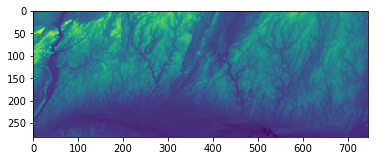

In [72]:
ma = np.ma.MaskedArray(model_grid.ned.values.reshape(NROW,NCOL), mask=(ib==0))
plt.imshow(model_grid.ned.values.reshape(NROW,NCOL))